<a href="https://www.kaggle.com/odins0n/emotion-detection?scriptVersionId=84496369" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="im"></a>
# <center>IMPORTING LIBRARIES</center> 

In [52]:
import pandas as pd
print("pandas")
import numpy as np
print("numpy")
import matplotlib.pyplot as plt
print("matplotlib")

pandas
numpy
matplotlib


In [53]:
import seaborn as sns
print("seaborn")
import plotly.express as px
print("plotly")


seaborn
plotly


In [54]:


from sklearn.metrics import confusion_matrix , classification_report 
print("confusion_matrix")
print("classification_report")
from sklearn.preprocessing import LabelBinarizer
print("LabelBinarizer")
from sklearn.metrics import roc_curve, auc, roc_auc_score
print("roc_curve")
print("auc")
print("roc_auc_score")

from IPython.display import clear_output
print("clear_output")
import warnings
warnings.filterwarnings('ignore')

confusion_matrix
classification_report
LabelBinarizer
roc_curve
auc
roc_auc_score
clear_output


In [55]:

import tensorflow as tf
print("tensorflow")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print("ImageDataGenerator")
from tensorflow.keras.utils import to_categorical
print("to_categorical")

tensorflow
ImageDataGenerator
to_categorical


<a id="hp"></a>
# <center>HYPERPARAMETRERS AND DIRECTORIES</center>

In [ ]:
train_dir = "data/train"  # Updated path
test_dir = "data/test"  # Updated path

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 50  # Increased epochs
FINE_TUNING_EPOCHS = 20  # Increased fine-tuning epochs
LR = 0.001  # Better initial learning rate
NUM_CLASSES = 7
EARLY_STOPPING_CRITERIA=7  # More patience
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
CLASS_LABELS_EMOJIS = ["👿", "🤢" , "😱" , "😊" , "😐 ", "😔" , "😲" ]

<a id="data"></a>
# <center> DATA LOADING AND PRE-PROCESSING</center>

In [ ]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

# Enhanced data augmentation for better generalization
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.15,  # Increased from 0.1
    height_shift_range=0.15,  # Increased from 0.05
    rotation_range=20,  # Added rotation
    zoom_range=0.15,  # Added zoom
    brightness_range=[0.8, 1.2],  # Added brightness variation
    shear_range=0.1,  # Added shear
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=preprocess_fun,
)

# Separate generator for test (no augmentation, only preprocessing)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_fun,
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    color_mode="rgb",
    class_mode="categorical",
    subset="training",
    seed=SEED,
)

validation_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation",
    seed=SEED,
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    color_mode="rgb",
    class_mode="categorical",
    seed=SEED,
)

# Calculate class weights to handle imbalance
class_counts = np.bincount(train_generator.classes)
total_samples = len(train_generator.classes)
class_weights = {i: total_samples / (NUM_CLASSES * count) for i, count in enumerate(class_counts)}
print(f"Class weights: {class_weights}")

In [58]:
# Ensure label order matches generator
CLASS_LABELS = list(train_generator.class_indices.keys())
print("Class order:", CLASS_LABELS)


Class order: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Images with different emotions

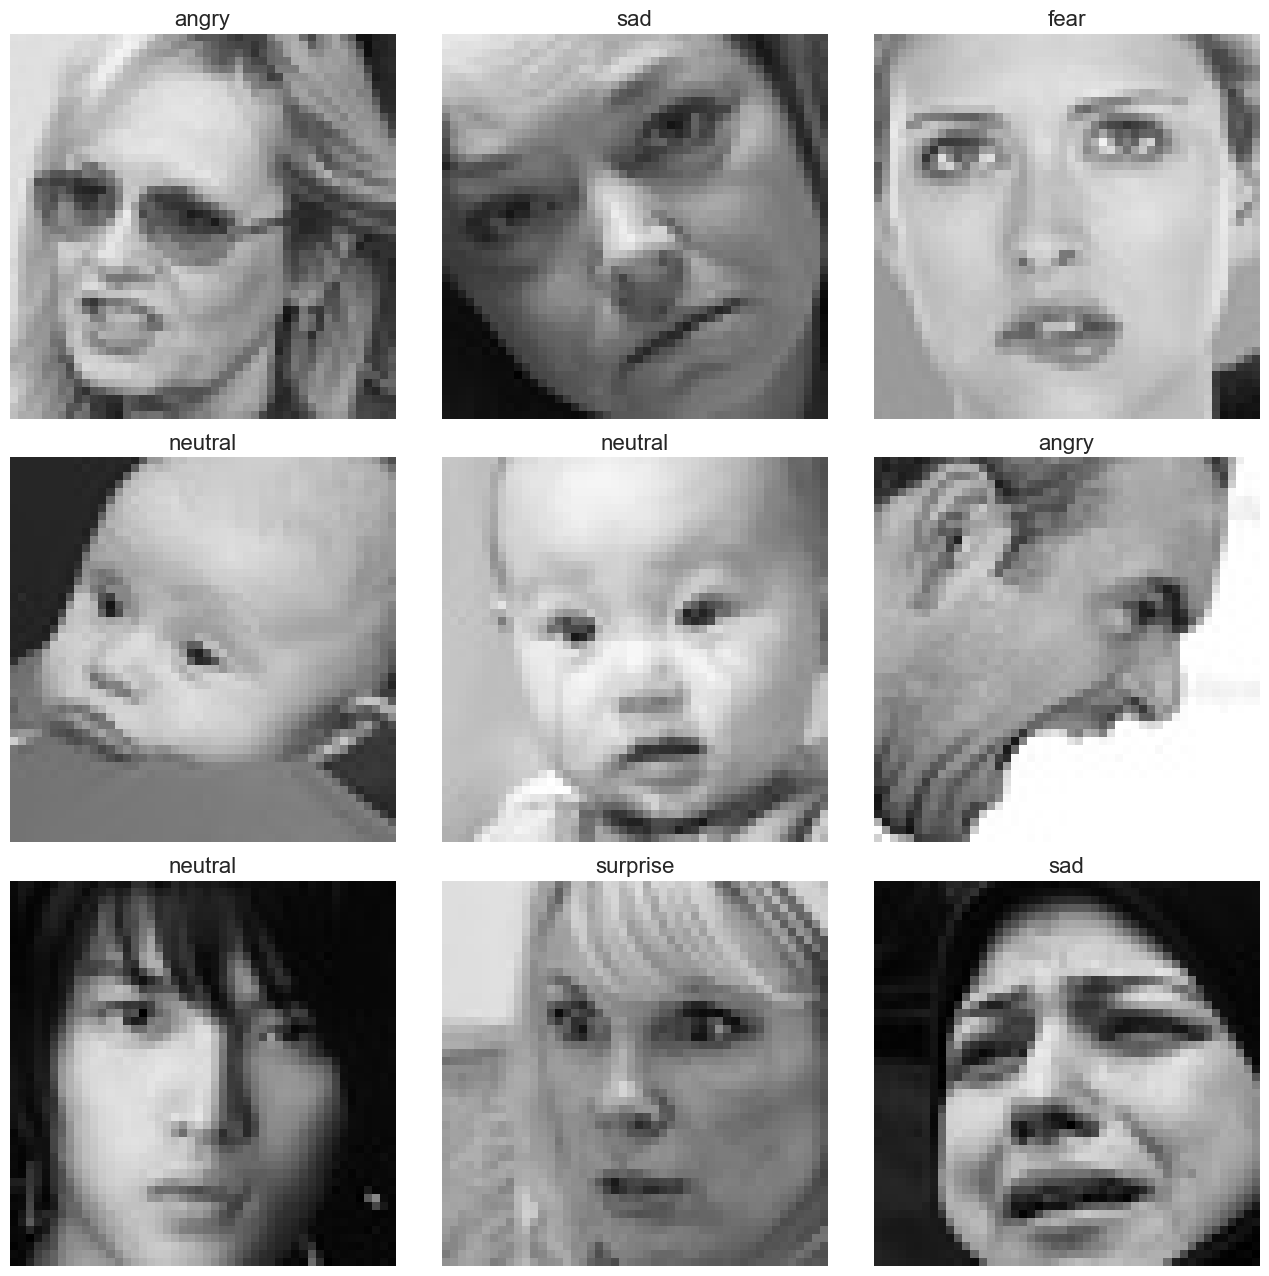

In [59]:
# Helper Functions
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)
    
def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )
clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1) 
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

## Data distribution (count) among differnt emotions

In [60]:
fig = px.bar(x = CLASS_LABELS_EMOJIS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

<a id="model"></a>
# <center> DenseNet169 Transfer Learning  </center>

In [ ]:
def feature_extractor(inputs):
    """DenseNet169 feature extractor"""
    feature_extractor = tf.keras.applications.DenseNet169(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights="imagenet"
    )(inputs)
    return feature_extractor

def classifier(inputs):
    """Improved classifier head with batch normalization"""
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    
    # First dense block
    x = tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # Reduced L2
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # Second dense block
    x = tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    
    # Third dense block
    x = tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Output layer
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    """Combined model"""
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    return classification_output

def define_compile_model():
    """Define and compile the improved model"""
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)

    # Use Adam with a good learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )

    return model

## Summary of model

In [62]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet169 (Functional)        │ (None, 1, 1, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1664)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       426,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,860,679 (52.87 MB)

 Trainable params: 1,217,799 (4.65 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

<a id="train"></a>
# <center> Training and Fine-Tuning </center> 

## Training model with freezed layers of DenseNer169

In [ ]:
# Enhanced callbacks for better training
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=EARLY_STOPPING_CRITERIA,
    verbose=1,
    restore_best_weights=True
)

# Learning rate reduction when validation loss plateaus
reduceLRCallback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Model checkpoint to save best model
checkpointCallback = tf.keras.callbacks.ModelCheckpoint(
    'models/best_emotion_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train with class weights to handle imbalance
history = model.fit(
    x=train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights,  # Handle class imbalance
    callbacks=[earlyStoppingCallback, reduceLRCallback, checkpointCallback]
)

history = pd.DataFrame(history.history)

## Fine Tuning

In [ ]:
# Fine-tuning: Unfreeze the last 50 layers of DenseNet for gradual unfreezing
model.layers[1].trainable = True

# Freeze all but the last 50 layers
for layer in model.layers[1].layers[:-50]:
    layer.trainable = False

print(f"Total layers: {len(model.layers[1].layers)}")
print(f"Trainable layers: {sum([layer.trainable for layer in model.layers[1].layers])}")

# Use a very small learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Very small LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Fine-tune with the same callbacks
history_ = model.fit(
    x=train_generator,
    epochs=FINE_TUNING_EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[earlyStoppingCallback, reduceLRCallback, checkpointCallback]
)

history = pd.concat([history, pd.DataFrame(history_.history)], ignore_index=True)

## Training plots

In [65]:
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] ,markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [66]:
x = px.line(data_frame= history , 
            y= ["loss" , "val_loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

<a id="vis"></a>
# <center> Visualizing Results </center> 

## Model Evaluation

In [67]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 226ms/step - accuracy: 0.4657 - loss: 1.4924
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 275ms/step


## Confusion Matrix

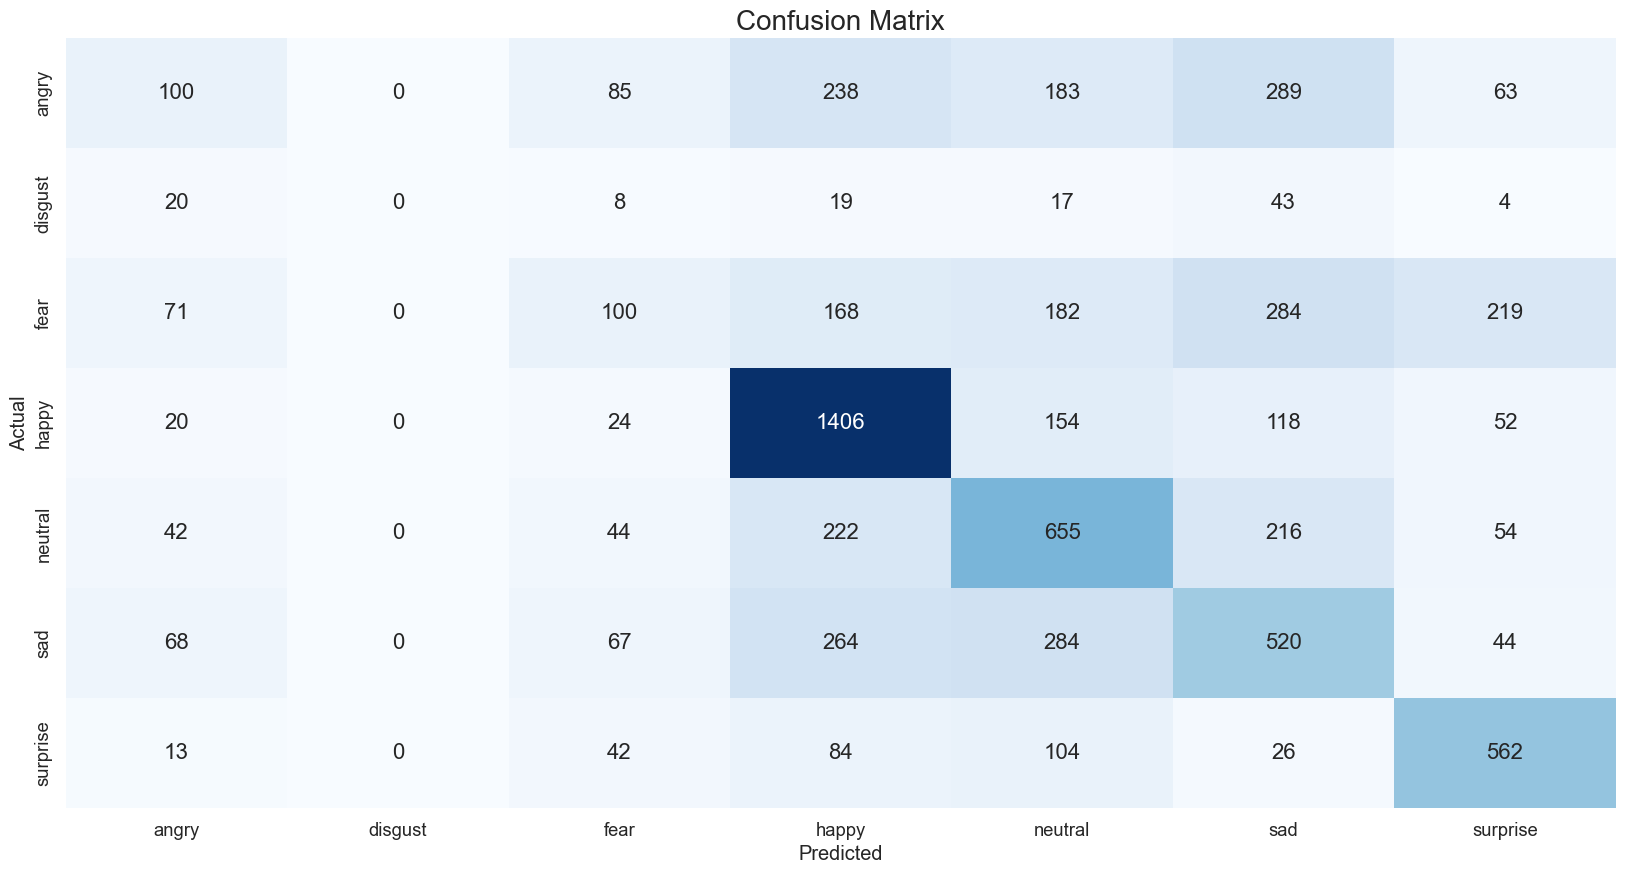

In [68]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

## Classification Report 

In [69]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.30      0.10      0.15       958
           1       0.00      0.00      0.00       111
           2       0.27      0.10      0.14      1024
           3       0.59      0.79      0.67      1774
           4       0.41      0.53      0.47      1233
           5       0.35      0.42      0.38      1247
           6       0.56      0.68      0.61       831

    accuracy                           0.47      7178
   macro avg       0.35      0.37      0.35      7178
weighted avg       0.42      0.47      0.42      7178



## Multiclass AUC Curve

ROC AUC score: 0.8271180783579062


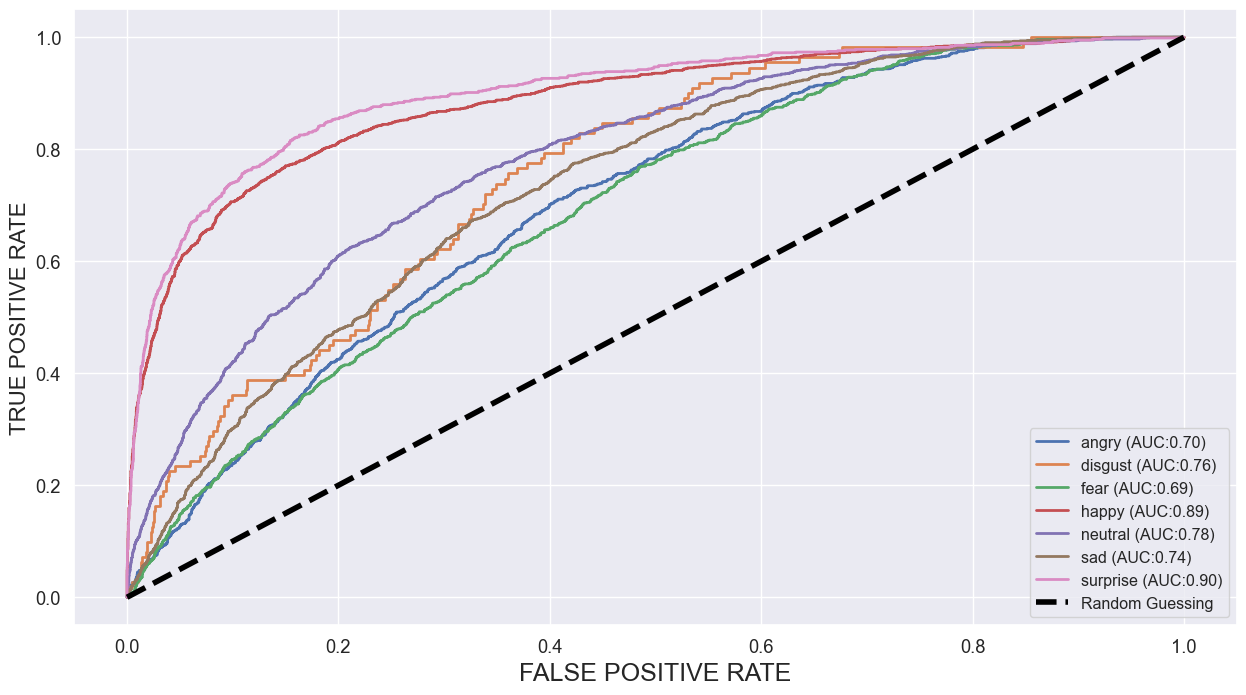

In [70]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [71]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.779304915557054


In [ ]:
import os
# Save the final model
save_path = "models/emotion_densenet.keras"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
model.save(save_path)
print(f"✓ Model saved to {save_path}")

# Also save model summary to text file
with open('models/model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
print("✓ Model summary saved to models/model_summary.txt")